Project root detected as: /Users/umama/Desktop/C_striatum_pangenome_project
Looking for: /Users/umama/Desktop/C_striatum_pangenome_project/data/processed/gene_presence_absence.Rtab
File exists: True
Genomes: 839
Gene families: 6361
Rarefaction table saved to: /Users/umama/Desktop/C_striatum_pangenome_project/data/processed/analysis_tables/rarefaction_curve_values.csv
Figure saved to: /Users/umama/Desktop/C_striatum_pangenome_project/figures/Figure_1_Rarefaction.png
Figure saved to: /Users/umama/Desktop/C_striatum_pangenome_project/figures/Figure_1_Rarefaction.pdf


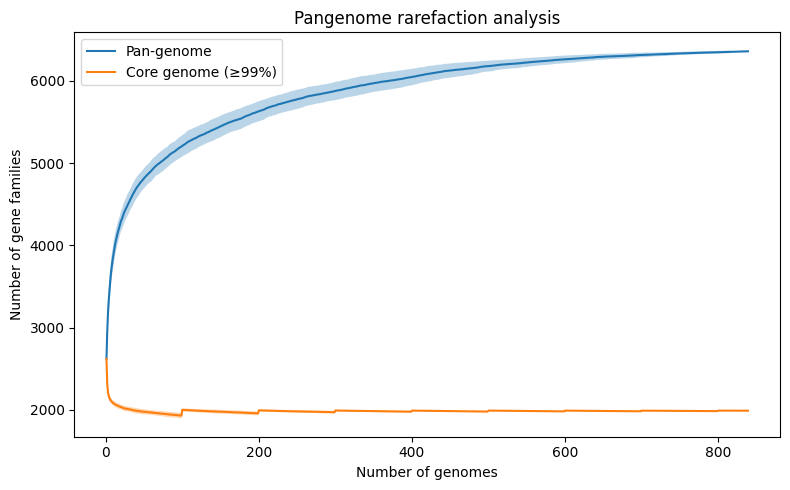

In [1]:
# ==============================
# Rarefaction Analysis Notebook
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Detect project root automatically
# ------------------------------

BASE_DIR = Path().resolve()

while not (BASE_DIR / "data").exists():
    BASE_DIR = BASE_DIR.parent

DATA_DIR = BASE_DIR / "data" / "processed"
TABLE_DIR = DATA_DIR / "analysis_tables"
FIGURE_DIR = BASE_DIR / "figures"

print("Project root detected as:", BASE_DIR)

# ------------------------------
# Load Panaroo Rtab file
# ------------------------------

rtab_path = DATA_DIR / "gene_presence_absence.Rtab"

print("Looking for:", rtab_path)
print("File exists:", rtab_path.exists())

rtab = pd.read_csv(rtab_path, sep="\t")

# First column = gene family IDs
gene_ids = rtab.iloc[:, 0]

# Remaining columns = binary presence/absence
presence_absence = rtab.iloc[:, 1:]

n_genomes = presence_absence.shape[1]
n_genes = presence_absence.shape[0]

print("Genomes:", n_genomes)
print("Gene families:", n_genes)

# ------------------------------
# Rarefaction function
# ------------------------------

def rarefaction_pan_core(matrix, n_iter=100, core_threshold=0.99):
    n_genomes = matrix.shape[1]
    pan_results = np.zeros((n_iter, n_genomes))
    core_results = np.zeros((n_iter, n_genomes))

    for i in range(n_iter):
        shuffled_cols = np.random.permutation(matrix.columns)
        cumulative_matrix = []

        for j, genome in enumerate(shuffled_cols):
            cumulative_matrix.append(matrix[genome].values)
            current_matrix = np.column_stack(cumulative_matrix)

            # PAN genome (union)
            pan_genes = np.sum(current_matrix, axis=1) > 0
            pan_results[i, j] = np.sum(pan_genes)

            # CORE genome (>= threshold)
            k = j + 1
            threshold = int(np.ceil(core_threshold * k))
            gene_counts = np.sum(current_matrix, axis=1)
            core_genes = gene_counts >= threshold
            core_results[i, j] = np.sum(core_genes)

    return pan_results, core_results

# ------------------------------
# Run rarefaction
# ------------------------------

pan_results, core_results = rarefaction_pan_core(
    presence_absence,
    n_iter=100,
    core_threshold=0.99
)

pan_mean = pan_results.mean(axis=0)
pan_std = pan_results.std(axis=0)

core_mean = core_results.mean(axis=0)
core_std = core_results.std(axis=0)

# ------------------------------
# Save rarefaction data table
# ------------------------------

rarefaction_df = pd.DataFrame({
    "number_of_genomes": np.arange(1, n_genomes + 1),
    "pan_mean": pan_mean,
    "pan_std": pan_std,
    "core_mean": core_mean,
    "core_std": core_std
})

output_table_path = TABLE_DIR / "rarefaction_curve_values.csv"
rarefaction_df.to_csv(output_table_path, index=False)

print("Rarefaction table saved to:", output_table_path)

# ------------------------------
# Plot rarefaction curves
# ------------------------------

plt.figure(figsize=(8,5))

x = np.arange(1, n_genomes + 1)

# Pan curve
plt.plot(x, pan_mean, label="Pan-genome")
plt.fill_between(
    x,
    pan_mean - pan_std,
    pan_mean + pan_std,
    alpha=0.3
)

# Core curve
plt.plot(x, core_mean, label="Core genome (≥99%)")
plt.fill_between(
    x,
    core_mean - core_std,
    core_mean + core_std,
    alpha=0.3
)

plt.xlabel("Number of genomes")
plt.ylabel("Number of gene families")
plt.title("Pangenome rarefaction analysis")

plt.legend()
plt.tight_layout()

# Save figure
figure_png_path = FIGURE_DIR / "Figure_1_Rarefaction.png"
figure_pdf_path = FIGURE_DIR / "Figure_1_Rarefaction.pdf"

plt.savefig(figure_png_path, dpi=300, bbox_inches="tight")
plt.savefig(figure_pdf_path, bbox_inches="tight")

print("Figure saved to:", figure_png_path)
print("Figure saved to:", figure_pdf_path)

plt.show()
